### This tutorial explains the steps followed to analyze the umbrella sampling results for Li/Na-ion transport in zeolites and obtaining the free energy, internal energy, and entropy profiles.


#### Please install 
#### https://github.com/learningmatter-mit/NeuralForceField
#### https://github.com/ochsenfeld-lab/adaptive_sampling

### Imports

In [1]:
path_to_adaptivesampling = "/home/sdeep77/adaptive_sampling" #update with your path

In [24]:
import os
import sys
sys.path.append(path_to_adaptivesampling)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ase import Atoms
from nff.train import load_model
from ase import units
from nff.io.ase import AtomsBatch
from nff.io.ase_calcs import NeuralFF
import shutil
#sys.path.append("/home/sdeep77/htvs")
#sys.path.append("/home/sdeep77/htvs/djangochem")
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
import time
from datetime import datetime
from torch.utils.data import DataLoader
from sklearn.metrics import mean_absolute_error
from nff.train.transfer import ChgnetLayerFreezer, MaceLayerFreezer
from nff.data import Dataset, split_train_validation_test, collate_dicts,concatenate_dict
from nff.train import Trainer, loss, hooks, metrics, evaluate
from nff.nn.models.mace import NffScaleMACE
from nff.nn.models.chgnet import CHGNetNFF
from nff.utils.constants import EV_TO_KCAL_MOL, HARTREE_TO_KCAL_MOL, KCAL_TO_EV

from nff.md.colvars import get_molecules, reconstruct_atoms
from ase.io import Trajectory
from ase.io import write, read, iread
from ase.build import make_supercell
#import nglview as nv
from tqdm import tqdm
from nff.md.nvt import Langevin
from nff.md.colvars import ColVar
from nff.io.bias_calculators import BiasBase
from nff.md.utils import BiasedNeuralMDLogger
from ase.optimize import BFGS
from nff.opt.algos import NeuralAseBFGS
device=0 #gpu_number or cpu



In [45]:
from adaptive_sampling.processing_tools import mbar
from adaptive_sampling.processing_tools import utils
from adaptive_sampling import units

In [4]:
# allow the use of LaTeX rendering and allow for serif
#plt.rc("text", usetex=True)
plt.rc("font", family="serif")

In [7]:
# the cv is in distance (Å)
min_val = -6.755041534253298 #-6.884143395590701 #as determined during the neural scan (See umbrella_sampling_scanning.py) 
max_val = -min_val
dval = 0.25#0.1  # step between minimizations
targets = np.arange(min_val, max_val+dval, dval) #use max_val+dval when max_val is not already set as max_val+dval
print(len(targets))
print(targets)



56
[-6.75504153e+00 -6.50504153e+00 -6.25504153e+00 -6.00504153e+00
 -5.75504153e+00 -5.50504153e+00 -5.25504153e+00 -5.00504153e+00
 -4.75504153e+00 -4.50504153e+00 -4.25504153e+00 -4.00504153e+00
 -3.75504153e+00 -3.50504153e+00 -3.25504153e+00 -3.00504153e+00
 -2.75504153e+00 -2.50504153e+00 -2.25504153e+00 -2.00504153e+00
 -1.75504153e+00 -1.50504153e+00 -1.25504153e+00 -1.00504153e+00
 -7.55041534e-01 -5.05041534e-01 -2.55041534e-01 -5.04153425e-03
  2.44958466e-01  4.94958466e-01  7.44958466e-01  9.94958466e-01
  1.24495847e+00  1.49495847e+00  1.74495847e+00  1.99495847e+00
  2.24495847e+00  2.49495847e+00  2.74495847e+00  2.99495847e+00
  3.24495847e+00  3.49495847e+00  3.74495847e+00  3.99495847e+00
  4.24495847e+00  4.49495847e+00  4.74495847e+00  4.99495847e+00
  5.24495847e+00  5.49495847e+00  5.74495847e+00  5.99495847e+00
  6.24495847e+00  6.49495847e+00  6.74495847e+00  6.99495847e+00]


### Umbrella sampling analysis

In [9]:
trajs = []
com_ext=[]
valid_targets_x=[]
pot_eners=[] #system potential energy 
time_steps=[]
temp=[]#can be obtained from window.log file

for ii, target in enumerate(targets):
    #truncated_target = f"{target:.10f}" #if there is mismatch in exact decimal value 
    try:
        data = np.genfromtxt(
        f"/data/grp_storage/sauradeep/jan29_umb_1ns/completed/us_zeo_450_window_{target}/us_zeo_450_window_{target}/window_ext.log",
        skip_header=1)
        traj=data[:, 4]
        time_step=data[:,0]
        pot_ener=data[:,2]
        
        #deleting indices that are not needed 
        indices_del = []
        for t in range(len(traj)):
            if traj[t] < min_val - dval or traj[t] > max_val + dval or time_step[t]<=2 or time_step[t]>800 or np.isnan(traj[t]) or np.isnan(pot_ener[t]): #(discard first 2ps  as equilibration) 
            #for 0 h2o system 600ps per window was carried out since no. of windows were much more
                indices_del.append(t)
                #print("Deleting the following index:", t)
    
    # Converting the list of indices to a set for faster lookup
        indices_del = set(indices_del)
    
    # Creating new arrays excluding the elements to be deleted
        traj = np.array([traj[t] for t in range(len(traj)) if t not in indices_del])
        filtered_data = np.array([data[t] for t in range(len(data)) if t not in indices_del])
        pot_ener=np.array([pot_ener[t] for t in range(len(pot_ener)) if t not in indices_del])
        time_step=np.array([time_step[t] for t in range(len(time_step)) if t not in indices_del])
        
        if traj.size == 0 or filtered_data.size == 0:
            print(f"Skipping target {target} as filtered trajectory is empty.")
            continue

        trajs.append(traj)
        com_ext.append(filtered_data)
        valid_targets_x.append(target)
        pot_eners.append(pot_ener)
        time_steps.append(time_step)
    
        print(ii,target)
    except Exception as e:
        print(e)


# The targets can also be read from the log files
meta_f = np.zeros(shape=(len(valid_targets_x), 3))
meta_f[:, 1] = valid_targets_x
# since we used ext_sigma and not ext_k, we need to calculate the k
# k = (RT)/(sigma**2)
meta_f[:, 2] = (8.314 * 450.0 / 1000.0) / ((dval/1.5)**2)#update ext_sigma according to the particular simulation (for eg, dval or dval/2...)

all_frames = trajs[0]
for traj in trajs[1:]:
    all_frames = np.concatenate((all_frames, traj))

#all_frames = np.concatenate(trajs, axis=0)

com_ext = np.vstack(com_ext)
print(len(trajs))
print(com_ext[:].shape)
#print(meta_f.shape)


0 -6.755041534253298
1 -6.505041534253298
2 -6.255041534253298
3 -6.005041534253298
4 -5.755041534253298
5 -5.505041534253298
6 -5.255041534253298
7 -5.005041534253298
8 -4.755041534253298
9 -4.505041534253298
10 -4.255041534253298
11 -4.005041534253298
12 -3.755041534253298
13 -3.505041534253298
14 -3.255041534253298
15 -3.005041534253298
16 -2.755041534253298
17 -2.505041534253298
18 -2.255041534253298
19 -2.005041534253298
20 -1.755041534253298
21 -1.505041534253298
22 -1.255041534253298
23 -1.005041534253298
24 -0.7550415342532979
25 -0.5050415342532979
26 -0.2550415342532979
27 -0.005041534253297897
28 0.2449584657467021
29 0.4949584657467021
30 0.7449584657467021
31 0.9949584657467021
32 1.244958465746702
33 1.494958465746702
34 1.744958465746702
35 1.994958465746702
36 2.244958465746702
37 2.494958465746702
38 2.744958465746702
39 2.994958465746702
40 3.244958465746702
41 3.494958465746702
42 3.744958465746702
43 3.994958465746702
44 4.244958465746702
45 4.494958465746702
46 4.7

In [10]:
np.isnan(com_ext).sum()

0

In [11]:
np.isnan(all_frames).sum()

0

In [12]:
print(len(valid_targets_x))

56


In [17]:
time_steps[28].shape

(39900,)

Text(0, 0.5, 'System energy/kJ mol$^{-1}$ ')

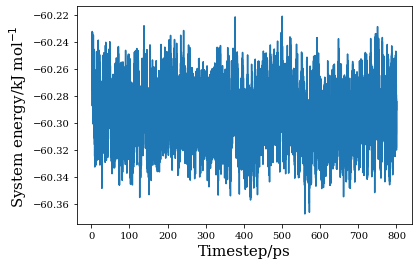

In [18]:
plt.plot(time_steps[29],pot_eners[29]/96.48531)
plt.xlabel('Timestep/ps', fontsize=15)
plt.ylabel('System energy/kJ mol$^{-1}$ ', fontsize=15)


In [19]:
all_frames.shape#for CV in x direction

(2193462,)

In [20]:
all_frames

array([-6.6471, -6.5102, -6.4615, ...,  6.9722,  6.9808,  6.9544])

In [21]:
#print(all_frames)
print((len(trajs)))
print(meta_f.shape)
print(meta_f)

56
(56, 3)
[[ 0.00000000e+00 -6.75504153e+00  1.34686800e+02]
 [ 0.00000000e+00 -6.50504153e+00  1.34686800e+02]
 [ 0.00000000e+00 -6.25504153e+00  1.34686800e+02]
 [ 0.00000000e+00 -6.00504153e+00  1.34686800e+02]
 [ 0.00000000e+00 -5.75504153e+00  1.34686800e+02]
 [ 0.00000000e+00 -5.50504153e+00  1.34686800e+02]
 [ 0.00000000e+00 -5.25504153e+00  1.34686800e+02]
 [ 0.00000000e+00 -5.00504153e+00  1.34686800e+02]
 [ 0.00000000e+00 -4.75504153e+00  1.34686800e+02]
 [ 0.00000000e+00 -4.50504153e+00  1.34686800e+02]
 [ 0.00000000e+00 -4.25504153e+00  1.34686800e+02]
 [ 0.00000000e+00 -4.00504153e+00  1.34686800e+02]
 [ 0.00000000e+00 -3.75504153e+00  1.34686800e+02]
 [ 0.00000000e+00 -3.50504153e+00  1.34686800e+02]
 [ 0.00000000e+00 -3.25504153e+00  1.34686800e+02]
 [ 0.00000000e+00 -3.00504153e+00  1.34686800e+02]
 [ 0.00000000e+00 -2.75504153e+00  1.34686800e+02]
 [ 0.00000000e+00 -2.50504153e+00  1.34686800e+02]
 [ 0.00000000e+00 -2.25504153e+00  1.34686800e+02]
 [ 0.00000000e+00 -2

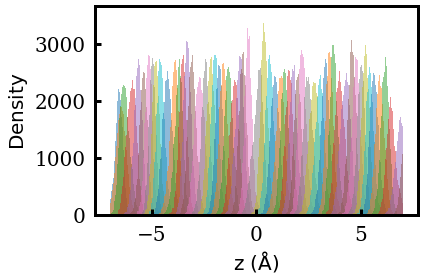

In [22]:
fig, ax = plt.subplots(1, sharex=True)

for traj, target in zip(trajs, valid_targets_x):
    ax.hist(traj, alpha=0.5, bins=50)

ax.spines['bottom'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
ax.tick_params(axis='y', length=6, width=3,
               labelsize=20, pad=10, direction='in')
ax.tick_params(axis='x', length=6, width=3,
               labelsize=20, pad=10, direction='in')

ax.set_ylabel(r'$\mathrm{Density}$', fontsize=20)
#ax.set_xlabel(r'CV', fontsize=20)
ax.set_xlabel(r'$\mathrm{z}\ (\mathrm{\AA})$', fontsize=20)
#axs.set_ylabel(r'$A(z)$ (kJ mol$^{-1})$', fontsize=20)
#ax.set_xlabel(r'$\mathrm{z}\ (\mathrm{\AA})$', fontsize=20)
#ax.set_xlabel(r'$\varphi$ / radian', fontsize=35)

#plt.savefig('/home/sdeep77/NeuralForceField/article_plots_0h2o_1li/umbrella_density_0h2o_1li.png', bbox_inches='tight',dpi=600)
plt.tight_layout()
plt.show()

In [25]:

exp_U, frames_per_traj = mbar.build_boltzmann(
    traj_list=trajs,
    meta_f=meta_f,
    equil_temp=450.0,
)
#print(len(exp_U))

weights = mbar.run_mbar(
    exp_U,
    frames_per_traj,
    outfreq=100,
    conv=1.0e-6,
    conv_errvec=None,
    max_iter=int(1e6),
    device=device,
)

tensor([1.6313e-05, 1.5314e-05, 1.5209e-05,  ..., 4.1999e-05, 4.3527e-05,
        3.9108e-05], device='cuda:0', dtype=torch.float64)
Start of the self-consistent iteration.
Iter    1:	Conv=  0.5667133983	Conv_errvec=  11256.037839
Iter  100:	Conv=  0.0115862501	Conv_errvec=    234.257049
Iter  200:	Conv=  0.0045291477	Conv_errvec=     94.304411
Iter  300:	Conv=  0.0037287545	Conv_errvec=     77.524431
Iter  400:	Conv=  0.0033137954	Conv_errvec=     67.090148
Iter  500:	Conv=  0.0028904533	Conv_errvec=     57.935058
Iter  600:	Conv=  0.0025067509	Conv_errvec=     49.966466
Iter  700:	Conv=  0.0021700755	Conv_errvec=     43.108881
Iter  800:	Conv=  0.0018775530	Conv_errvec=     37.218503
Iter  900:	Conv=  0.0016241731	Conv_errvec=     32.152636
Iter 1000:	Conv=  0.0014049110	Conv_errvec=     27.788639
Iter 1100:	Conv=  0.0012152310	Conv_errvec=     24.024193
Iter 1200:	Conv=  0.0010511576	Conv_errvec=     20.773820
Iter 1300:	Conv=  0.0009092379	Conv_errvec=     17.965512
Iter 1400:	Conv

In [26]:
print(weights.shape)

(2193462,)


In [27]:
# grid for PMF
minimum = all_frames.min()
maximum = all_frames.max()
bin_width = dval
grid = np.arange(minimum, maximum, bin_width)

In [28]:
grid.shape

(57,)

In [29]:
pmf, rho = mbar.pmf_from_weights(grid, all_frames, weights, equil_temp=450.0) #all_frames and CV_x same

In [30]:
pmf.shape

(57,)

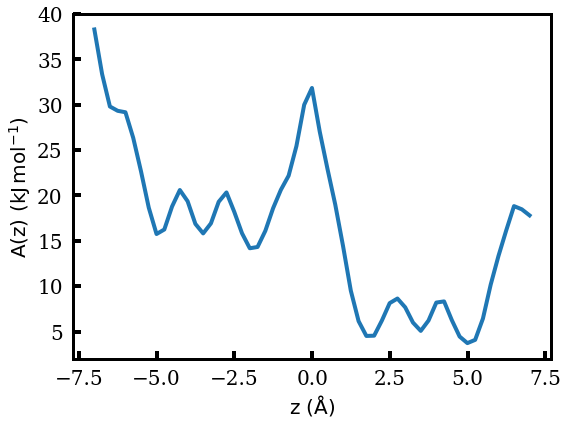

In [31]:
# PMF: free energy profile along CV
fig, axs = plt.subplots(1, figsize=(8, 6))


axs.plot(grid, pmf, linewidth=4)

axs.tick_params(axis='y', length=8, width=4,
                labelsize=20, pad=10, direction='in')
axs.tick_params(axis='x', length=8, width=4,
                labelsize=20, pad=10, direction='in')

#axs.set_xlabel(r'$z$', fontsize=20)
axs.set_xlabel(r'$\mathrm{z}\ (\mathrm{\AA})$', fontsize=20)
axs.set_ylabel(r'$\mathrm{A(z)}\ (\mathrm{kJ}\,\mathrm{mol}^{-1})$', fontsize=20)
axs.spines['bottom'].set_linewidth(3)
axs.spines['top'].set_linewidth(3)
axs.spines['left'].set_linewidth(3)
axs.spines['right'].set_linewidth(3)

#plt.savefig('/home/sdeep77/NeuralForceField/article_plots_167h2o_1li/pmf_167h2o_1li_color2.png', bbox_inches='tight',dpi=600)

#plt.savefig('/home/sdeep77/NeuralForceField/feb24_umb_0.5ns_na/pmf_na.png', dpi=600,bbox_inches='tight')#ext_sigma=dval/1.5
fig.tight_layout()
plt.show()

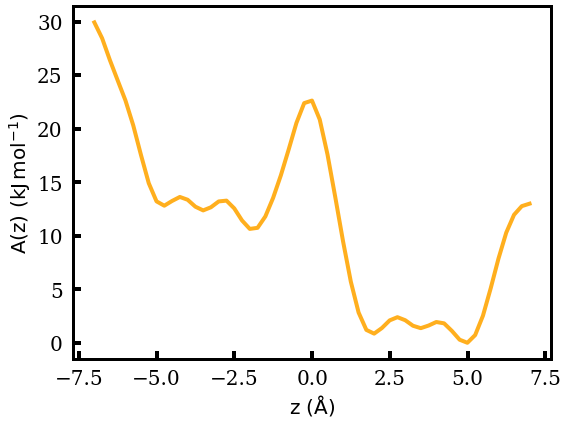

In [32]:
from scipy.ndimage import gaussian_filter1d
# PMF: free energy profile along CV
fig, axs = plt.subplots(1, figsize=(8, 6))
colors = ['#0000a5', '#ac5775', '#ffaf1e'] #['#001969', '#975851', '#ffa500']

smooth_pmf = gaussian_filter1d(pmf, 1.5) # choose reasonable smoothing
smooth_pmf -= smooth_pmf.min()


axs.plot(grid, smooth_pmf, linewidth=4, color=colors[2])

axs.tick_params(axis='y', length=8, width=4,
                labelsize=20, pad=10, direction='in')
axs.tick_params(axis='x', length=8, width=4,
                labelsize=20, pad=10, direction='in')
#axs.set_xlabel(r'$z\ (\AA)$', fontsize=20)
axs.set_xlabel(r'$\mathrm{z}\ (\mathrm{\AA})$', fontsize=20)
axs.set_ylabel(r'$\mathrm{A(z)}\ (\mathrm{kJ}\,\mathrm{mol}^{-1})$', fontsize=20)
axs.spines['bottom'].set_linewidth(3)
axs.spines['top'].set_linewidth(3)
axs.spines['left'].set_linewidth(3)
axs.spines['right'].set_linewidth(3)

#plt.savefig('/home/sdeep77/NeuralForceField/article_plots_167h2o_1li/pmf_167h2o_1li_smoothened_color2.png', dpi=600,bbox_inches='tight')#ext_sigma=dval/1.5
fig.tight_layout()
plt.show()

### Attempting Block averaging for mean and uncertainty  


In [34]:
# Randomly shuffle the indices of all configurations
N_configs = len(all_frames)
indices = np.arange(N_configs)
np.random.shuffle(indices)

# Divide the indices into 10 blocks
n_blocks = 10
block_indices = np.array_split(indices, n_blocks)

pmf_blocks = []  # To store PMF profile for each block

for i, idx_block in enumerate(block_indices):
    # Select the frames and weights corresponding to the current block
    block_frames = all_frames[idx_block]
    block_weights = weights[idx_block]
    
    # Compute the PMF for this block using your mbar function.
    # Here, pmf_from_weights returns (pmf, rho). We only use pmf.
    pmf_block, _ = mbar.pmf_from_weights(grid, block_frames, block_weights, equil_temp=450.0)
    pmf_blocks.append(pmf_block)
    print(f"Block {i+1}: computed PMF profile with {len(pmf_block)} bins.")

# Convert list of block PMFs to an array: shape (n_blocks, n_bins)
pmf_blocks = np.array(pmf_blocks)

# Compute the mean PMF and the standard deviation across blocks at each bin
mean_pmf = np.mean(pmf_blocks, axis=0)
std_pmf = np.std(pmf_blocks, axis=0, ddof=1)
stderr_pmf = std_pmf / np.sqrt(n_blocks)

Block 1: computed PMF profile with 57 bins.
Block 2: computed PMF profile with 57 bins.
Block 3: computed PMF profile with 57 bins.
Block 4: computed PMF profile with 57 bins.
Block 5: computed PMF profile with 57 bins.
Block 6: computed PMF profile with 57 bins.
Block 7: computed PMF profile with 57 bins.
Block 8: computed PMF profile with 57 bins.
Block 9: computed PMF profile with 57 bins.
Block 10: computed PMF profile with 57 bins.


In [35]:
mean_pmf.shape

(57,)

In [36]:
std_pmf

array([0.23841578, 0.07370695, 0.04349305, 0.07429524, 0.07180604,
       0.07100817, 0.07290635, 0.02132311, 0.03084067, 0.05830564,
       0.08268992, 0.06840518, 0.06342424, 0.07999127, 0.04742855,
       0.05479388, 0.0584533 , 0.07411802, 0.04360375, 0.04235044,
       0.05023218, 0.06794204, 0.03213489, 0.05213075, 0.08481032,
       0.06964176, 0.07305576, 0.06624003, 0.10692138, 0.05565176,
       0.05796208, 0.02889065, 0.07966842, 0.07903172, 0.06653093,
       0.04292559, 0.02763336, 0.05350189, 0.0584941 , 0.056882  ,
       0.0413242 , 0.02397502, 0.03202591, 0.04363424, 0.05859823,
       0.05126919, 0.05068282, 0.05813882, 0.05538782, 0.04617941,
       0.06038609, 0.04638915, 0.06501614, 0.07515807, 0.08792304,
       0.08264189, 0.08688716])

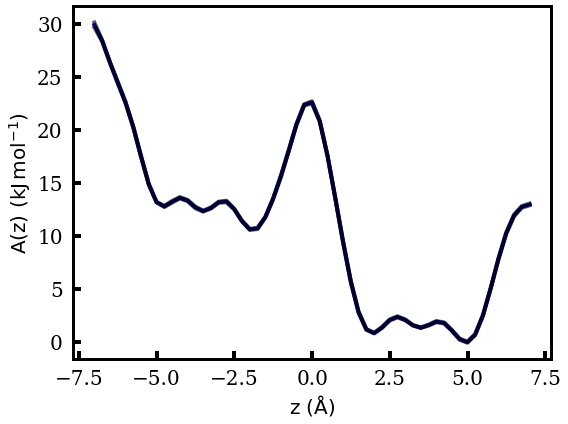

In [37]:
from scipy.ndimage import gaussian_filter1d
# PMF: free energy profile along CV
fig, axs = plt.subplots(1, figsize=(8, 6))


smooth_mean_pmf = gaussian_filter1d(mean_pmf, 1.5) # choose reasonable smoothing
#smooth_std_pmf = gaussian_filter1d(std_pmf, 1.5) # choose reasonable smoothing
smooth_mean_pmf -= smooth_mean_pmf.min()


axs.plot(grid, smooth_mean_pmf, linewidth=4, color='blue', label='Mean PMF')
axs.plot(grid, smooth_mean_pmf+std_pmf, linewidth=4, linestyle='-', color='black', alpha=0.6)
axs.plot(grid, smooth_mean_pmf-std_pmf, linewidth=4, linestyle='-', color='black', alpha=0.6)
# axs.fill_between(
#     grid,
#     smooth_mean_pmf - std_pmf,
#     smooth_mean_pmf + std_pmf,
#     color='blue',
#     alpha=0.3,
#     label='± 1 Std. Dev.'
# )

axs.tick_params(axis='y', length=8, width=4,
                labelsize=20, pad=10, direction='in')
axs.tick_params(axis='x', length=8, width=4,
                labelsize=20, pad=10, direction='in')

#axs.set_xlabel(r'$z\ (\AA)$', fontsize=20)
axs.set_xlabel(r'$\mathrm{z}\ (\mathrm{\AA})$', fontsize=20)
axs.set_ylabel(r'$\mathrm{A(z)}\ (\mathrm{kJ}\,\mathrm{mol}^{-1})$', fontsize=20)

axs.spines['bottom'].set_linewidth(3)
axs.spines['top'].set_linewidth(3)
axs.spines['left'].set_linewidth(3)
axs.spines['right'].set_linewidth(3)


#plt.savefig('/home/sdeep77/NeuralForceField/article_plots_0h2o_1li/pmf_mean_std_0h2o_1li.png', dpi=600,bbox_inches='tight')#ext_sigma=dval/1.5
fig.tight_layout()
plt.show()

### Entropy and energy profiles


In [38]:
# com_ext = trajectory of extended system file, numpy array
# com_ext.shape = (num_frames, columns in file)

Ds = utils.conditional_average(grid, 
                               all_frames[:], 
                               np.abs(com_ext[:][:, 8])/(com_ext[:][:, 3]*com_ext[:][:, 7]),
                               weights)
D = utils.conditional_average(grid, 
                              all_frames[:], 
                              np.abs(com_ext[:][:, 8]),
                              weights)
mxi_inv = utils.conditional_average(grid, 
                              all_frames[:], 
                              com_ext[:][:, 6],
                              weights)

mxi_inv_sqrt = utils.conditional_average(grid, 
                              all_frames[:], 
                              np.sqrt(com_ext[:][:, 6]),
                              weights)

U_mxi_sqrt = utils.conditional_average(grid, 
                              all_frames[:], 
                              np.sqrt(com_ext[:][:, 6])*com_ext[:][:, 2]*96.48531, # conversion of eV to kJ/mol
                              weights)

In [39]:
np.isnan(weights).sum()

0

In [40]:
com_ext.shape

(2193462, 9)

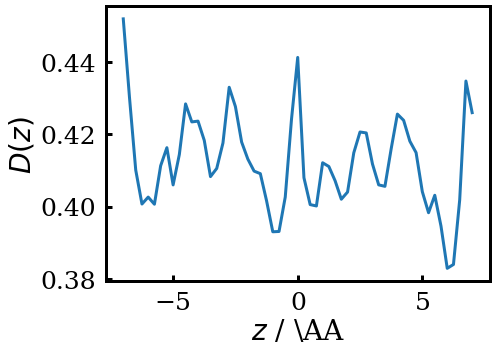

In [41]:
fig, ax = plt.subplots(1, figsize=(7,5), sharex=True)

ax.plot(grid, D[0], 
        linewidth=3)

ax.set_xlabel(r'$z$ / \AA', fontsize=28)
ax.set_ylabel(r'$D(z)$ ', fontsize=28)

ax.tick_params(axis='y',length=6,width=3,labelsize=25, pad=10, direction='in')
ax.tick_params(axis='x',length=6,width=3,labelsize=25, pad=10, direction='in')
ax.spines['bottom'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)

plt.tight_layout()
#plt.savefig(f"{name}_D.png", dpi=400)
plt.show()

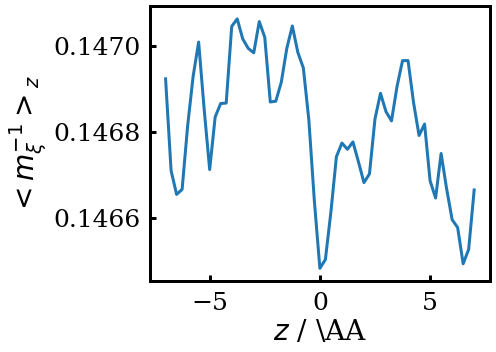

In [42]:
#in principle, this should be a  straight line..in our case..its a small change in the order of 0.001
fig, ax = plt.subplots(1, figsize=(7,5), sharex=True)

ax.plot(grid, mxi_inv[0], 
        linewidth=3)

ax.set_xlabel(r'$z$ / \AA', fontsize=28)
ax.set_ylabel(r'$<m_\xi^{-1}>_z$ ', fontsize=28)

ax.tick_params(axis='y',length=6,width=3,labelsize=25, pad=10, direction='in')
ax.tick_params(axis='x',length=6,width=3,labelsize=25, pad=10, direction='in')
ax.spines['bottom'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)

plt.tight_layout()
#plt.savefig(f"{name}_mxi_inv.png", dpi=400)
plt.show()

In [43]:
pmf

masked_array(data=[38.286347621709886, 33.354371908345726,
                   29.798172749119463, 29.324512795346642,
                   29.163856420787276, 26.344736972421526,
                   22.665333492195877, 18.65616371933391,
                   15.748641219127144, 16.246535247477045,
                   18.78477737672744, 20.596169018885448,
                   19.359085659811328, 16.863915421864984,
                   15.816473278338124, 16.92340834328681,
                   19.300492144681733, 20.33285048356988,
                   18.197598807448433, 15.829145456812194,
                   14.179992037245169, 14.322017704003517,
                   16.099071213407832, 18.592606998099846,
                   20.61722857505923, 22.180544052986146,
                   25.433643743313933, 29.98955733539271,
                   31.84069901803511, 27.035915979852863,
                   22.912978115414273, 18.980304034351583,
                   14.422494386657002, 9.50755770100039,
      

In [46]:
T = 450.0 #make you sure you are putting in here the right temperature


lambda_xi = np.sqrt(units.h_in_SI * units.h_in_SI * mxi_inv[0] / 
                    (2.0 * np.pi * units.atomic_to_kg * units.kB_in_SI * T)
                   )

lambda_xi *= 1e10 # from A to m



F_z = - 8.314 * T / 1000.0 * np.log(rho * lambda_xi)
F_z -= F_z.min()
E_z = U_mxi_sqrt[0] / mxi_inv_sqrt[0]
E_z -= E_z.min()
TS_z = E_z - F_z

In [47]:
E_z

array([35.21334274, 38.23758434, 39.85454229, 57.84370409, 87.58234084,
       74.56264418, 44.44105957, 14.42640293,  0.        ,  7.26821382,
       24.24549209, 50.68492798, 48.7693499 , 27.4000746 , 19.05566027,
       35.74433699, 62.3604369 , 70.15235496, 35.24129593, 29.45122925,
       29.2729526 , 33.60789373, 73.51708355, 78.12147165, 44.70225026,
       22.4261431 , 22.19313414, 35.26494873, 50.54970288, 69.11351589,
       67.66521775, 58.03537942, 52.72062907, 42.56120809, 48.68291491,
       38.20175645, 19.27473095, 12.41044929, 14.43521867, 25.53031674,
       35.2110514 , 44.39221278, 42.14494263, 37.61659657, 34.52697288,
       42.87053632, 37.55131932, 27.5511434 , 26.84549466, 41.56616159,
       51.83547681, 38.26786424, 26.45088015, 24.8288422 , 31.79153154,
       43.07994492, 42.94407336])

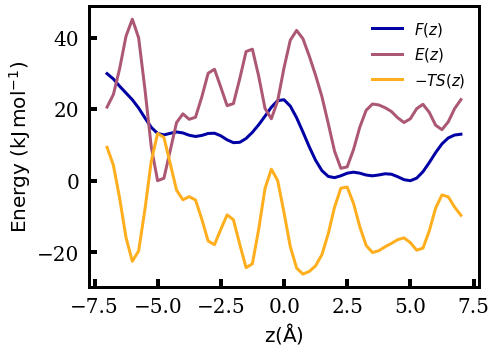

In [48]:
colors = ['#0000a5', '#ac5775', '#ffaf1e'] #['#001969', '#975851', '#ffa500']
from scipy.ndimage import gaussian_filter1d

fig, ax = plt.subplots(1, figsize=(7,5), sharex=True)

smooth_Ez = gaussian_filter1d(E_z, 1.5) # choose reasonable smoothing
smooth_Ez -= smooth_Ez.min()

smooth_Fz = gaussian_filter1d(F_z, 1.5) # choose reasonable smoothing
smooth_Fz -= smooth_Fz.min()

ax.plot(grid, smooth_Fz, 
        linewidth=3, label=r"$F(z)$", color=colors[0])
ax.plot(grid, smooth_Ez, 
        linewidth=3, label=r"$E(z)$", color=colors[1])
ax.plot(grid, -(smooth_Ez - smooth_Fz), 
        linewidth=3, label=r"$-TS(z)$", color=colors[2])


ax.set_xlabel(r'$\mathrm{z} (\mathrm{\AA})$', fontsize=20)
#ax.set_xlabel(r'$\mathrm{CV}\ (\mathrm{\AA})$', fontsize=20)
ax.set_ylabel(r'$\mathrm{Energy}\ (\mathrm{kJ}\,\mathrm{mol}^{-1})$', fontsize=20)

ax.tick_params(axis='y',length=8,width=4,labelsize=20, pad=10, direction='in')
ax.tick_params(axis='x',length=8,width=4,labelsize=20, pad=10, direction='in')
ax.set_xticks([-7.5,-5.0,-2.5,0.0,2.5,5.0,7.5])
#ax.set_yticks([-30,-25,-20,-15,-10,-5, 0,5,10,15,20,25,30])
ax.spines['bottom'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)

plt.tight_layout()
plt.legend(frameon=False, loc=1, fontsize=15)
#plt.savefig(f"F_E_TS.png", dpi=400)
#plt.savefig('/home/sdeep77/NeuralForceField/article_plots_0h2o_1li/entropy_energy_smoothened_0h2o_1li.png')
plt.show()

### computing energy barrier using analytical expression


In [49]:
# The following two functions can be found at 
# https://github.com/ochsenfeld-lab/adaptive_sampling/blob/main/adaptive_sampling/processing_tools/utils.py
# but they are given here explicitly for easier understanding

# all calculations are done in SI units
# - mxi_inv has the unit of [CV-unit / (Angstrom^2 * a.m.u.)],
#   therefore the factors of atomic_to_kg and 1e10 to adjust to [CV-unit / (m^2 * kg)],
#   then lambda has the unit of [CV-unit]
# - rho has the unit of [CV-unit^{-1}]
# - Hence, rho*lambda is dimensionless
# - P(A) is a probility and therefore also dimensionless


def reaction_freeE(
    pmf: np.ndarray,
    T: float = 450.0,
    min_bin: int = 20,
    max_bin: int = -20,
    TS: int = None,
) -> tuple:
    """calculate free energy difference
       see: Dietschreit et al., J. Chem. Phys. 156, 114105 (2022); https://doi.org/10.1063/5.0083423

    Args:
        pmf: potential of mean force (free energy surface)
        T: temperature
        min_bin/max_bin: minimum/maximum bin for search of transition state
        TS: alternatively, bin number of TS

    Returns:
        dA (float): free energy difference
        dA_grid (np.ndarray): free energy difference on grid
    """
    RT = (units.R_in_SI * T) / 1000.0
    pmf = pmf[~np.isnan(pmf)]

    if TS == None:
        TS = np.where(pmf == np.amax(pmf[min_bin:max_bin]))[0][0]

    P = np.exp(-pmf / RT)
    P /= P.sum()

    P_a = P[:TS].sum()
    P_b = P[(TS + 1) :].sum()

    dA = RT * np.log(P_a / P_b)
    dA_grid = np.zeros(len(pmf))
    dA_grid[TS] += dA / 2
    dA_grid[(TS + 1) :] += dA
    dA_approx = pmf[TS:].min() - pmf[:TS].min()

    return dA, dA_grid, dA_approx


def activation_freeE(
    pmf: np.ndarray,
    m_xi_inv: np.ndarray,
    T: float = 450.0,
    min_bin: int = 20,
    max_bin: int = -20,
    TS: int = None,
) -> tuple:
    """calculate activation free energy
       see: Dietschreit et al., J. Chem. Phys. XX, XXX (2022); https://doi.org/XXXX

    Args:
        pmf: potential of mean force (free energy surface)
        m_xi_inv: z-conditioned average of inverse mass associates with CV, expected units are xi^2/(au_mass * angstrom^2)
        T: temperature
        min_bin/max_bin: minimum/maximum bin for search of transition state
        TS: alternatively, bin number of TS

    Returns:
        dA (float): free energy difference
        dA_grid (np.ndarray): free energy difference on grid
    """
    RT = (units.R_in_SI * T) / 1000.0  # kJ/mol

    pmf = pmf[~np.isnan(pmf)]
    if TS == None:
        TS = np.where(pmf == np.amax(pmf[min_bin:max_bin]))[0][0]

    rho = np.exp(-pmf / RT)
    P = rho / rho.sum()  # normalize so that P_a + P_b = 1.0

    #lambda_xi has already been computed before at beginning of grid
    # lambda_xi = np.sqrt(
    #     (units.h_in_SI * units.h_in_SI * m_xi_inv[TS]) / (2.0 * np.pi * atomic_to_kg * units.kB_in_SI * T)
    # )#m_xi_inv[TS] only has 2 array entries (of size 57 each)
    # lambda_xi *= 1e10 # to adjust from Angstrom to meter

    P_a = P[:TS].sum()
    P_b = P[(TS + 1) :].sum()

    dA_a2b = -RT * np.log((rho[TS] * lambda_xi) / P_a)
    dA_b2a = -RT * np.log((rho[TS] * lambda_xi) / P_b)
    dA_a2b_approx = pmf[TS] - pmf[:TS].min()
    dA_b2a_approx = pmf[TS] - pmf[TS:].min()

    return dA_a2b, dA_b2a, dA_a2b_approx, dA_b2a_approx

In [50]:
grid[28] #already computed before during PMF estimation, TS in this case occurs roughly at z=0

-0.0049000000000001265

In [52]:
DeltaA, DeltaA_grid, DeltaA_approx = reaction_freeE(smooth_pmf, T = 450.0,TS=28)
DAact_forw, DAact_backw, DAact_forw_approx, DAact_backw_approx = activation_freeE(smooth_pmf, mxi_inv, T = 450.0,TS=28)

In [53]:
mxi_inv[0].shape


(57,)

In [54]:
print(f"The reaction free energy is: {DeltaA:2.1f} kJ/mol.")
print(f"The difference between the minima on the PMF is: {DeltaA_approx:2.1f} kJ/mol.")

print(f"\nThe forward reaction activation free energy (kJ/mol) is:{DAact_forw}")
print(f"The difference between the maximum and left minimum on the PMF is: {DAact_forw_approx:3.1f} kJ/mol.")

print(f"\nThe backward  reaction activation free energy (kJ/mol)is: {DAact_backw}")
print(f"The difference between the maximum and right minimum on the PMF is: {DAact_backw_approx:3.1f} kJ/mol.")

The reaction free energy is: -11.1 kJ/mol.
The difference between the minima on the PMF is: -10.6 kJ/mol.

The forward reaction activation free energy (kJ/mol) is:[15.65804793 15.66076568 15.66147174 15.66132278 15.65944491 15.65797421
 15.65696008 15.65894583 15.66073552 15.65917541 15.65877816 15.65876624
 15.65649684 15.65627514 15.65686754 15.65714734 15.65727906 15.65635507
 15.65682105 15.65873274 15.65871089 15.6581466  15.65714537 15.65648497
 15.65726559 15.65772552 15.65926906 15.66166714 15.66366367 15.66340224
 15.6619918  15.66035412 15.65994898 15.6601345  15.65991589 15.66050448
 15.66112204 15.66086267 15.65923651 15.65847655 15.65902006 15.65929326
 15.65827518 15.65750952 15.65750872 15.65875264 15.65972601 15.6593871
 15.66106667 15.66157877 15.66025818 15.66130302 15.66221927 15.66245259
 15.66352969 15.66310115 15.66133869]
The difference between the maximum and left minimum on the PMF is: 12.0 kJ/mol.

The backward  reaction activation free energy (kJ/mol)is: [26.